In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score
import time

In [20]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [21]:
# Read in data from small csv to a dataframe
df1=pd.read_csv('weather_small.csv', sep=',')

# Reformat data in date/time column 
df1['Formatted Date'] =  pd.to_datetime(df1['Formatted Date'])

# Create a new column for year / month / hour
df1['Year'] = pd.DatetimeIndex(df1['Formatted Date']).year
df1['Month'] = pd.DatetimeIndex(df1['Formatted Date']).month
df1['Hour'] = pd.DatetimeIndex(df1['Formatted Date']).hour

# Encode month and hour for cyclical nature
df1 = encode(df1, 'Month', 13)
df1 = encode(df1, 'Hour', 23)
df1 = encode(df1, 'Wind Bearing (degrees)', 359)

# Remove original date/time column
df1=df1.drop(['Formatted Date'],axis=1)

# Convert columns to factors
df1['Summary'] = df1['Summary'].astype('category')
df1['Precip Type'] = df1['Precip Type'].astype('category')
df1['Daily Summary'] = df1['Daily Summary'].astype('category')

# Create a column stating whether its mostly cloudy / overcast or not in summary
df1['Heavy_Cloud'] = pd.np.where(df1.Summary.str.contains("Mostly Cloudy"), 1,
                    pd.np.where(df1.Summary.str.contains("Overcast"), 1,
                    pd.np.where(df1.Summary.str.contains("Foggy"), 1,0)))

# Convert to boolean and print count
df1['Heavy_Cloud']=df1['Heavy_Cloud'].astype('bool')

In [22]:
### Standardize continous variables
X=scale(df1[['Temperature (C)','Apparent Temperature (C)','Humidity','Wind Speed (km/h)',
    'Wind Bearing (degrees)_cos','Wind Bearing (degrees)_sin','Visibility (km)','Loud Cover','Pressure (millibars)',
    'Year','Month_sin','Month_cos',
    'Hour_sin','Hour_cos']])
X=pd.DataFrame(X,columns=['Temperature (C)','Apparent Temperature (C)','Humidity','Wind Speed (km/h)',
    'Wind Bearing (degrees)_cos','Wind Bearing (degrees)_sin','Visibility (km)','Loud Cover','Pressure (millibars)',
    'Year','Month_sin','Month_cos',
    'Hour_sin','Hour_cos'])

In [23]:
### Encode Categorical Variables
temp=pd.get_dummies(df1, columns=["Precip Type"])
cols = pd.Series(range(0,20))

temp.drop(temp.columns[cols],axis=1,inplace=True)
# print(X.shape)
# print(temp.shape)
X=pd.concat([X,temp],axis=1)
# print(X.shape)
# print(X.dtypes)

y=df1["Heavy_Cloud"]

In [24]:
### Create training, validation and test data
# Create Training&Validation / Test set - split of 70/20/10
X_intermediate, X_test, y_intermediate, y_test = train_test_split(X,y,test_size=0.1) 
X_valid, X_train, y_valid, y_train = train_test_split(X_intermediate, y_intermediate,
                                                      test_size=0.78)
# delete intermediate variables
X_intermediate, y_intermediate

print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(df1),2),
                                                       round(len(y_valid)/len(df1),2),
                                                       round(len(y_test)/len(df1),2)))

train: 0.7% | validation: 0.2% | test 0.1%


In [25]:
# create the RFE model and select 3 attributes
lrm = LogisticRegression()
rfe = RFE(lrm, 6)
rfe = rfe.fit(X_train,y_train)
# summarize the selection of the attributes
# print(rfe.support_)
# print(rfe.ranking_)
# print(X.shape)
# print(X.dtypes)

In [26]:
### Create new value for X based on strongest variables
X=pd.DataFrame(X,columns=['Temperature (C)','Apparent Temperature (C)','Humidity','Wind Speed (km/h)',
    'Month_cos','Visibility (km)'])

In [27]:
### Create training, validation and test data
# Create Training&Validation / Test set - split of 70/20/10
X_intermediate, X_test, y_intermediate, y_test = train_test_split(X,y,test_size=0.1) 
X_valid, X_train, y_valid, y_train = train_test_split(X_intermediate, y_intermediate,
                                                      test_size=0.78)
# delete intermediate variables
X_intermediate, y_intermediate

print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(df1),2),
                                                       round(len(y_valid)/len(df1),2),
                                                       round(len(y_test)/len(df1),2)))

train: 0.7% | validation: 0.2% | test 0.1%


In [28]:
start_time = time.clock()
# Fit a logistic regression model to the training data
lrm = LogisticRegression()
model = lrm.fit(X_train,y_train)
print (time.clock() - start_time, "seconds")

### Print coefficients
print('Coefficeints',lrm.coef_)

# Reshape validation data so that model can be run
X_valid=X_valid.values.reshape(-1,6)
# Predictions on validation data
predictions = model.predict(X_valid)

0.017828999999999873 seconds
Coefficeints [[-0.60630916  0.91555408  0.6664069   0.48874502  0.46529234 -0.40787721]]


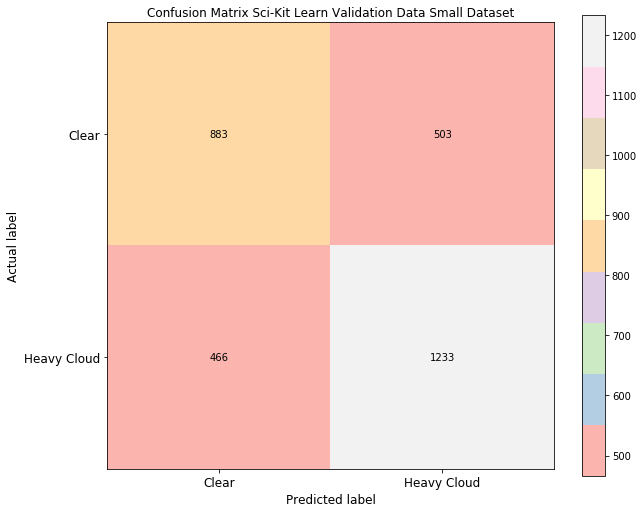

In [29]:
# Confusion Matrix
cm = metrics.confusion_matrix(y_valid, predictions)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion Matrix Sci-Kit Learn Validation Data Small Dataset', size = 12)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Clear", "Heavy Cloud"], size = 12)
plt.yticks(tick_marks, ["Clear", "Heavy Cloud"], size = 12)
plt.tight_layout()
plt.ylabel('Actual label', size = 12)
plt.xlabel('Predicted label', size = 12)
width, height = cm.shape
for x in range(width):
 for y in range(height):
  plt.annotate(str(cm[x][y]), xy=(y, x), 
  horizontalalignment='center',
  verticalalignment='center')

plt.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7 ,wspace=0.5)
plt.savefig('Logistic_Regression_Validation_Confusion_Small_SK.png',pdi=600)

In [30]:
Score=lrm.score(X_valid, y_valid)
ERR=1-Score

Recall = (cm[0,0])/(np.sum(cm,axis=1)[0])

FPR=(cm[1,0])/(np.sum(cm,axis=1)[1])
Specificity=1-FPR

FNR=1-Recall

print('Score of validation model: ',Score)
print('Error rate of validation model: ',ERR)
print('Recall / TPR of validation model: ',Recall)
print('FNR of validation model: ',FNR)
print('Specificity / TNR of validation model: ',Specificity)
print('FPR of validation model: ',FPR)

Score of validation model:  0.6858995137763371
Error rate of validation model:  0.31410048622366293
Recall / TPR of validation model:  0.637085137085137
FNR of validation model:  0.36291486291486297
Specificity / TNR of validation model:  0.7257210123602119
FPR of validation model:  0.2742789876397881


AUC of validation model 0.6814030747226746


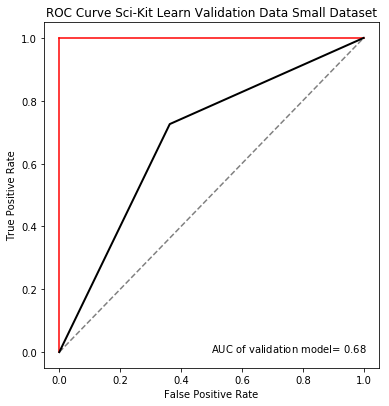

In [31]:
### calculate ROC Score
print("AUC of validation model",roc_auc_score(y_valid, predictions))
fpr, tpr, _ = metrics.roc_curve(y_valid, predictions)

fig, ax1=plt.subplots(figsize=(6,6))
x1 = [0, 0]
x2 = [0,1]
y1=[0,1]
y2=[1,1]
ax1.plot(x1, y1, 'red')
ax1.plot(x2, y2, 'red')
ax1.plot(x2, y1, 'grey',linestyle='--')

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve Sci-Kit Learn Validation Data Small Dataset')
ax1.plot(fpr,tpr,color='Black',linewidth=2,label='ROC Curve')

textstr = 'AUC of validation model= $%.2f$'%(roc_auc_score(y_valid, predictions))
ax1.text(0.5,0,textstr)

fig.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7 ,wspace=0.5)
fig.savefig('Logistic_Regression_Validation_ROC_Small_SK.png',pdi=600)

In [32]:
# Reshape test data so that model can be run
X_test=X_test.values.reshape(-1,6)
# Predictions on validation data
predictions_test = model.predict(X_test)

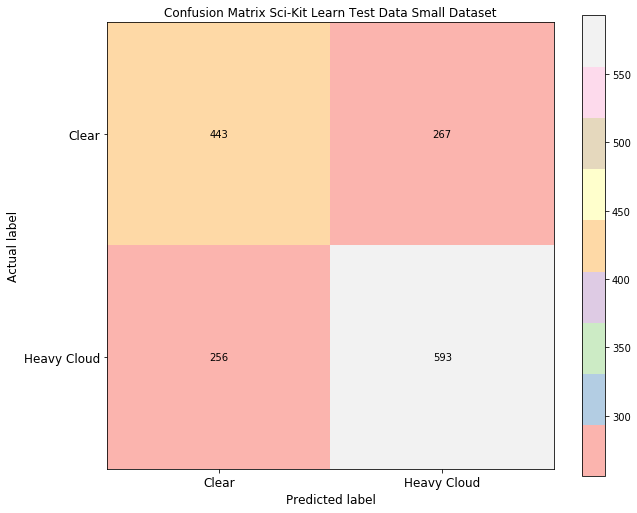

In [33]:
# Confusion Matrix
cm2 = metrics.confusion_matrix(y_test, predictions_test)
plt.figure(figsize=(10,8))
plt.imshow(cm2, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion Matrix Sci-Kit Learn Test Data Small Dataset', size = 12)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Clear", "Heavy Cloud"], size = 12)
plt.yticks(tick_marks, ["Clear", "Heavy Cloud"], size = 12)
plt.tight_layout()
plt.ylabel('Actual label', size = 12)
plt.xlabel('Predicted label', size = 12)
width, height = cm2.shape
for x in range(width):
 for y in range(height):
  plt.annotate(str(cm2[x][y]), xy=(y, x), 
  horizontalalignment='center',
  verticalalignment='center')

plt.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7 ,wspace=0.5)
plt.savefig('Logistic_Regression_Test_Confusion_Small_SK.png',pdi=600)

In [34]:
Score=lrm.score(X_test, y_test)
ERR=1-Score

FPR=(cm2[1,0])/(np.sum(cm2,axis=1)[1])
Specificity=1-FPR
Recall = (cm2[0,0])/(np.sum(cm2,axis=1)[0])
FNR=1-Recall

print('Score of test model: ',Score)
print('Error rate of test model: ',ERR)
print('Recall / TPR of test model: ',Recall)
print('FNR of test model: ',FNR)
print('Specificity / TNR of test model: ',Specificity)
print('FPR of test model: ',FPR)

Score of test model:  0.6645285439384221
Error rate of test model:  0.3354714560615779
Recall / TPR of test model:  0.6239436619718309
FNR of test model:  0.37605633802816907
Specificity / TNR of test model:  0.6984687868080095
FPR of test model:  0.30153121319199055


AUC of validation model 0.6612062243899203


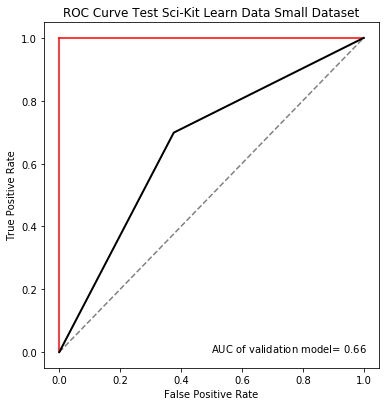

In [35]:
### calculate ROC Score
print("AUC of validation model",roc_auc_score(y_test, predictions_test))
fpr, tpr, _ = metrics.roc_curve(y_test, predictions_test)

fig, ax1=plt.subplots(figsize=(6,6))
x1 = [0, 0]
x2 = [0,1]
y1=[0,1]
y2=[1,1]
ax1.plot(x1, y1, 'red')
ax1.plot(x2, y2, 'red')
ax1.plot(x2, y1, 'grey',linestyle='--')

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve Test Sci-Kit Learn Data Small Dataset')
ax1.plot(fpr,tpr,color='Black',linewidth=2,label='ROC Curve')

textstr = 'AUC of validation model= $%.2f$'%(roc_auc_score(y_test, predictions_test))
ax1.text(0.5,0,textstr)

fig.subplots_adjust(top=0.9, bottom=0.1, left=0.125, right=0.9, hspace=0.7 ,wspace=0.5)
fig.savefig('Logistic_Regression_Test_ROC_Small_SK.png',pdi=600)